In [10]:
!pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines #gym-anytrading gym

**Importing Dataset**

In [11]:
import pandas as pd

df = pd.read_csv('https://github.com/ene610/DRL_finance/blob/main/data/Binance_BTCUSDT_minute.csv?raw=true', skiprows=1)
df = df.rename(columns={'Volume USDT': 'volume'})
df = df.iloc[::-1]
df = df.drop(columns=['symbol', 'Volume BTC'])
df['date'] = pd.to_datetime(df['unix'],unit='ms')
df = df.set_index("date")
df = df.drop(columns=['unix'])
print(df.shape)
df.head(5)

(330483, 6)


,open,high,low,close,volume,tradecount
date,,,,,,
2020-09-11 20:40:00,10317.00,10317.01,10314.36,10316.00,340398.477553,342
2020-09-11 20:41:00,10316.00,10321.09,10316.00,10319.50,168497.705251,256
2020-09-11 20:42:00,10319.50,10320.31,10318.49,10319.34,125108.931436,193
2020-09-11 20:43:00,10319.34,10320.14,10318.89,10319.00,139806.963489,187
2020-09-11 20:44:00,10318.99,10319.72,10316.58,10319.47,149266.708094,284


**Implementing Env**

In [12]:
# Gym stuff
import gym

# Stable baselines - rl stuff
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C

# Processing libraries
import numpy as np
from enum import Enum
from matplotlib import pyplot as plt

In [13]:
from enum import Enum

class Actions(Enum):
    # Mappo sono le azioni legittime nella forma:
    # StatoAzione
    DoNothing = 0
    OpenPosition = 1
    HoldPosition = 2
    ClosePosition = 3

    # Potrei anche mappare solo le quattro azioni e poi dare il reward negativo sull'azione in base alla posizione corrente (che comunque devo tenermi salvata)


class Positions(Enum):
    # La posizione è lo stato attuale in cui si trova l'algoritmo.
    # In Free è permesso solo di fare DoNothing e OpenPosition
    # in Long è permesso di fare solo HoldPosition e ClosePosition
    Free = 0
    Long = 1

    def opposite(self):
        return Positions.Free if self == Positions.Long else Positions.Long

In [78]:
from gym import spaces
from gym.utils import seeding

class CryptoTradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}

    def __init__(self, df, frame_bound, window_size):
        assert df.ndim == 2
        assert len(frame_bound) == 2

        self.seed()
        self.df = df
        self.frame_bound = frame_bound
        self.window_size = window_size
        self.prices, self.signal_features = self._process_data()
        self.shape = (window_size, self.signal_features.shape[1])

        # spaces
        self.action_space = spaces.Discrete(len(Actions))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float32)

        # episode
        self._balance = 10000.
        self._start_tick = self.window_size
        self._end_tick = len(self.prices) - 1
        self._done = None
        self._current_tick = None
        self._open_position_tick = None
        self._last_trade_tick = None
        self._position = Positions.Free
        self._position_history = None
        self._total_reward = 0.
        self._total_profit = 0.
        self._balance = 10000
        self._first_rendering = None
        self.history = None

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        self._balance = 10000.
        self._done = False
        self._current_tick = self._start_tick
        self._open_position_tick = 0
        self._last_trade_tick = self._current_tick - 1
        self._position = Positions.Free
        self._position_history = (self.window_size * [0]) + [self._position]
        self._total_reward = 0.
        self._total_profit = 0.  # unit
        self._first_rendering = True
        self.history = {}
        return self._get_observation()

    def step(self, action):
        '''
        Responsabilità di step():
            1. calcolare il profit attraverso la funzione di update_profit
            2. calcolare step_reward, position, open_position_tick tramite la funzione calculate_reward()
            4. aggiornare la history delle posizioni
        '''
        self._done = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._done = True

        self._update_profit(action)
        # Attenzione! self._position viene cambiata in step_reward quindi update_profit() deve essere chiamato prima
        step_reward = self._calculate_reward(action)

        self._position_history.append(self._position)
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            balance = self._balance,
            position = self._position.value
        )
        self._update_history(info)

        return observation, step_reward, self._done, info

    def _calculate_reward(self, action):
        '''
        Responsabilità di calculate_reward:
            1. Calcolare il reward
            2. Aggiornare self._total_reward
            3. Aggiornare self._position
            4. Aggiornare self._open_position_tick

        Logica di reward per azioni LEGITTIME:
                    - ClosePosition (da Long a Free) = profit di quella posizione
                    - OpenPosition (da Free a Long) = reward di incentivo per aprire posizione
                    - HoldPosition (da Long a Long) = profit che verrebbe fatta da quando si è aperta la posizione se si vendesse in quel momento
                    - DoNothing (da Free a Free) = 0 di reward, non punisco e lo incentivo in nessun modo su questa posizione

        Logica di reward per azioni ILLEGITTIME (tutte le coppie non listate sopra):
                    - Do un piccolo reward negativo di disincentivo per tutte le azioni illeggitime
                        ma non faccio cambiare il sistema

        Funzione di transizione: (Stato, Azione) -> Stato

        :param action:
        :return:
        '''
        step_reward = -1
        new_position = self._position

        # (Free, DoNothing) -> Free
        if action == Actions.DoNothing.value and self._position == Positions.Free:
            step_reward = 0

        # (Free, OpenPosition) -> Long
        elif action == Actions.OpenPosition.value and self._position == Positions.Free:
            new_position = self._position.opposite()
            self._open_position_tick = self._current_tick
            step_reward = 0.95

        # (Long, HoldPosition) -> Long
        elif action == Actions.HoldPosition.value and self._position == Positions.Long:
            current_price = self.prices[self._current_tick]
            open_position_price = self.prices[self._open_position_tick]
            price_diff = current_price - open_position_price
            step_reward += price_diff

        # (Long, ClosePosition) -> Free
        elif action == Actions.ClosePosition.value and self._position == Positions.Long:
            new_position = self._position.opposite()
            current_price = self.prices[self._current_tick]
            open_position_price = self.prices[self._open_position_tick]
            price_diff = current_price - open_position_price
            step_reward += price_diff

        self._total_reward += step_reward
        self._position = new_position
        return step_reward

    def _update_profit(self, action):
        '''
        Responsabilità di update_profit():
            1. Aggiornare self._total_profit con il profit reale
            2. Aggiornare self._balance con il balance dopo la chiusura della transazione
        :param action:
        :return:
        '''

        temp_balance = self._balance
        if action == Actions.ClosePosition.value and self._position == Positions.Long:
            current_price = self.prices[self._current_tick]
            open_position_price = self.prices[self._open_position_tick]
            self._balance = (self._balance / open_position_price) * current_price
            #se total profit inizializzato a 0
            self._total_profit += self._balance - temp_balance


    def _get_observation(self):
        return self.signal_features[(self._current_tick - self.window_size):self._current_tick]

    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    def render(self, mode='human'):
        def _plot_position(position, tick):
            color = None
            if position == Positions.Free:
                color = 'red'
            elif position == Positions.Long:
                color = 'green'
            if color:
                plt.scatter(tick, self.prices[tick], color=color)

        if self._first_rendering:
            self._first_rendering = False
            plt.cla()
            plt.plot(self.prices)
            start_position = self._position_history[self._start_tick]
            _plot_position(start_position, self._start_tick)

        _plot_position(self._position, self._current_tick)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit + ' ~ ' +
            "Total Balance: %.6f" % self._balance
        )

        plt.pause(0.01)

    # def render_all(self, mode='human'):
    #     window_ticks = np.arange(len(self._position_history))
    #     plt.plot(self.prices)
    #
    #     short_ticks = []
    #     long_ticks = []
    #     for i, tick in enumerate(window_ticks):
    #         if self._position_history[i] == Positions.Free:
    #             short_ticks.append(tick)
    #         elif self._position_history[i] == Positions.Long:
    #             long_ticks.append(tick)
    #
    #     plt.plot(short_ticks, self.prices[short_ticks], 'ro')
    #     plt.plot(long_ticks, self.prices[long_ticks], 'go')
    #
    #     plt.suptitle(
    #         "Total Reward: %.6f" % self._total_reward + ' ~ ' +
    #         "Total Profit: %.6f" % self._total_profit + ' ~ ' +
    #         "Balance: %.6f" % self._balance
    #     )

    def render_all(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        plt.plot(self.prices)

        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks):
            if i != 0:
                current_tick = self._position_history[i]
                prev_tick = self._position_history[i - 1]
                if current_tick != prev_tick:
                    if current_tick == Positions.Free:
                        short_ticks.append(tick)
                    elif current_tick == Positions.Long:
                        long_ticks.append(tick)

        plt.plot(short_ticks, self.prices[short_ticks], 'ro')
        plt.plot(long_ticks, self.prices[long_ticks], 'go')

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit + ' ~ ' +
            "Balance: %.6f" % self._balance
        )

    def close(self):
        plt.close()

    def save_rendering(self, filepath):
        plt.savefig(filepath)

    def pause_rendering(self):
        plt.show()

    def _process_data(self):
        prices = self.df['close'].to_numpy()

        prices[self.frame_bound[0] - self.window_size]  # validate index (TODO: Improve validation)
        prices = prices[self.frame_bound[0]-self.window_size:self.frame_bound[1]]

        diff = np.insert(np.diff(prices), 0, 0)
        signal_features = np.column_stack((prices, diff))

        return prices, signal_features

    #############################################################################################################

    def max_possible_profit(self):  # trade fees are ignored
        raise NotImplementedError

**Register and Init Env**

In [79]:
id_str = 'cryptostocks-v1'

del  gym.envs.registry.env_specs['cryptostocks-v1']

from gym.envs.registration import register
register(
    id=id_str,
    entry_point=CryptoTradingEnv,
)

**Declare and Train Agent**

In [80]:
env_maker = lambda: gym.make(id_str, df=df, frame_bound=(22,10000), window_size=22)
env = DummyVecEnv([env_maker])

In [76]:
model = A2C('MlpLstmPolicy', env, verbose=1) 
model.learn(total_timesteps=150000)

---------------------------------
| explained_variance | 0.0236   |
| fps                | 16       |
| nupdates           | 1        |
| policy_entropy     | 1.38     |
| total_timesteps    | 5        |
| value_loss         | 4.72     |
---------------------------------
----------------------------------
| explained_variance | -0.000198 |
| fps                | 276       |
| nupdates           | 100       |
| policy_entropy     | 1.38      |
| total_timesteps    | 500       |
| value_loss         | 11.9      |
----------------------------------
----------------------------------
| explained_variance | -4.57e-05 |
| fps                | 301       |
| nupdates           | 200       |
| policy_entropy     | 1.38      |
| total_timesteps    | 1000      |
| value_loss         | 16.8      |
----------------------------------
----------------------------------
| explained_variance | -0.000251 |
| fps                | 313       |
| nupdates           | 300       |
| policy_entropy     | 1.38 

info {'total_reward': -125.50000000000364, 'total_profit': 49.77584592848689, 'balance': 10049.775845928487, 'position': 1}


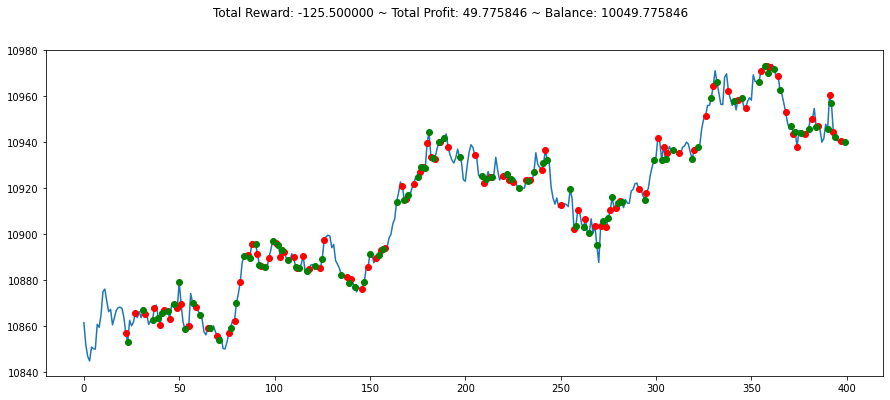

info {'total_reward': -107.5899999999765, 'total_profit': 71.2294691071711, 'balance': 10071.229469107171, 'position': 1}


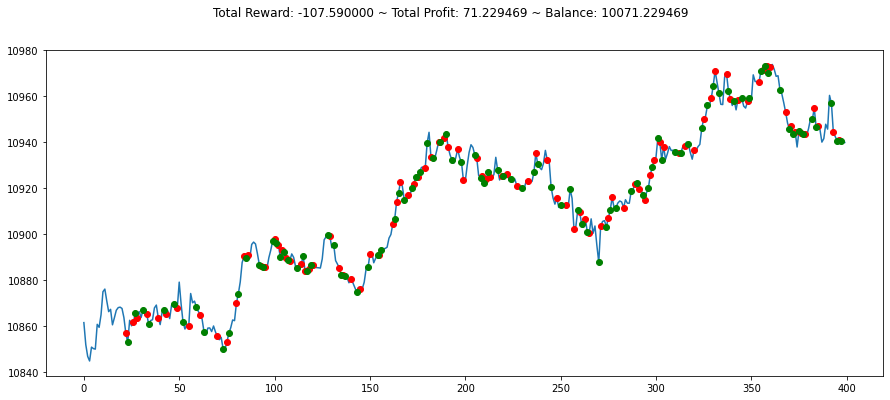

info {'total_reward': -181.9599999999973, 'total_profit': 7.216750150251755, 'balance': 10007.216750150252, 'position': 1}


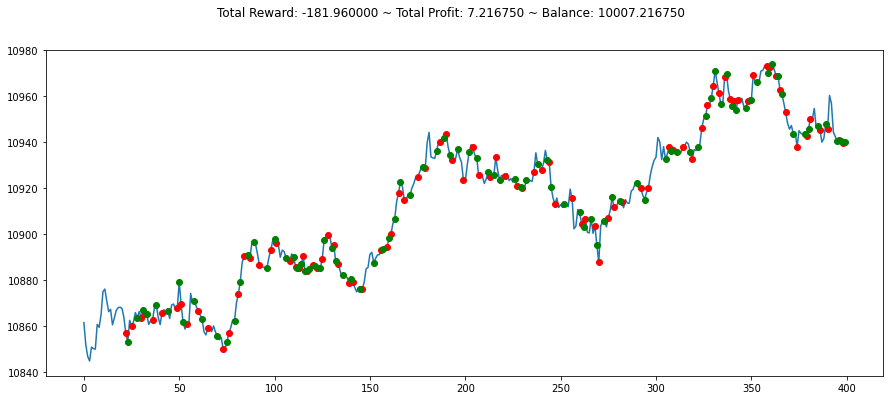

info {'total_reward': -163.82000000000335, 'total_profit': 22.318140243627568, 'balance': 10022.318140243628, 'position': 1}


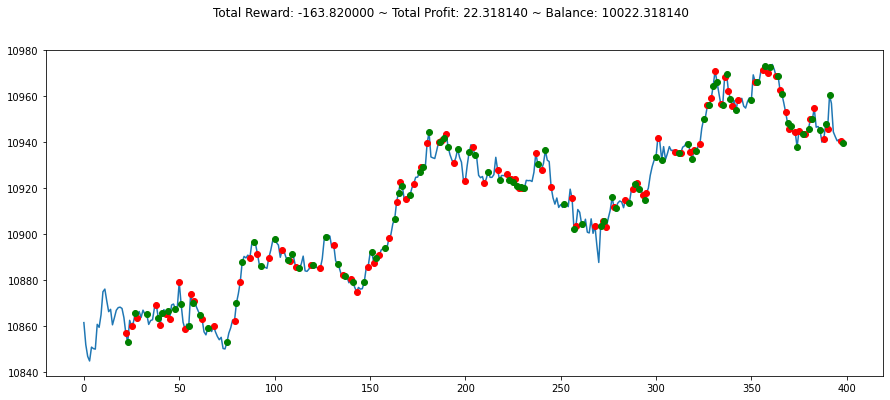

info {'total_reward': -210.7500000000109, 'total_profit': -5.316883136794786, 'balance': 9994.683116863205, 'position': 0}


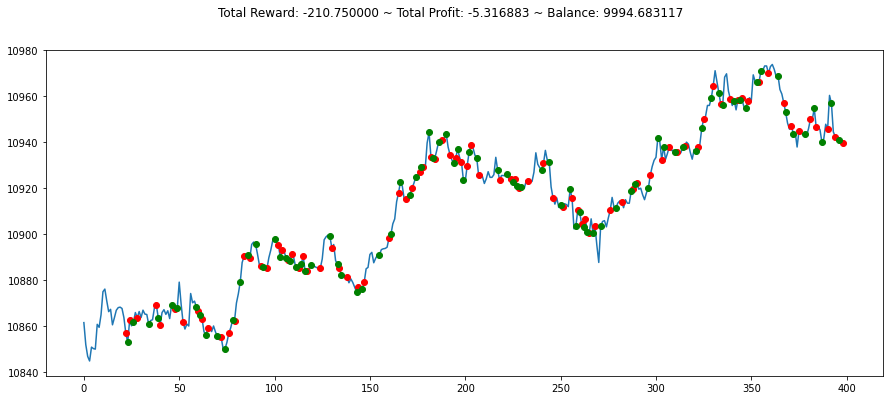

info {'total_reward': -155.35000000001492, 'total_profit': 31.055952073096705, 'balance': 10031.055952073097, 'position': 0}


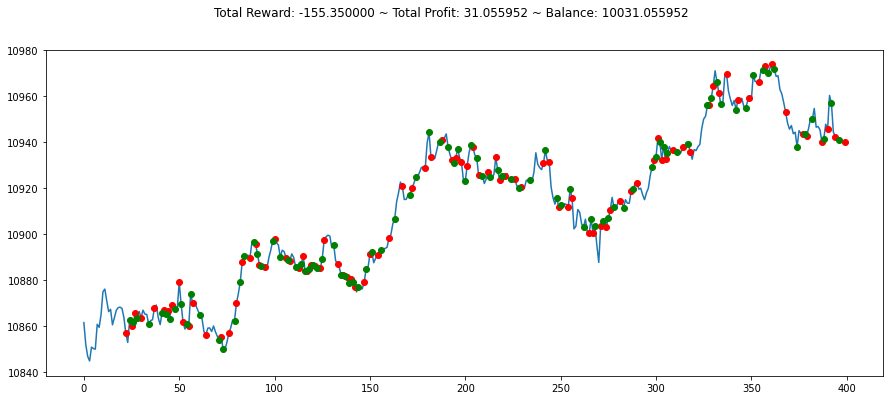

info {'total_reward': -209.04999999999927, 'total_profit': -3.2860432087454683, 'balance': 9996.713956791255, 'position': 0}


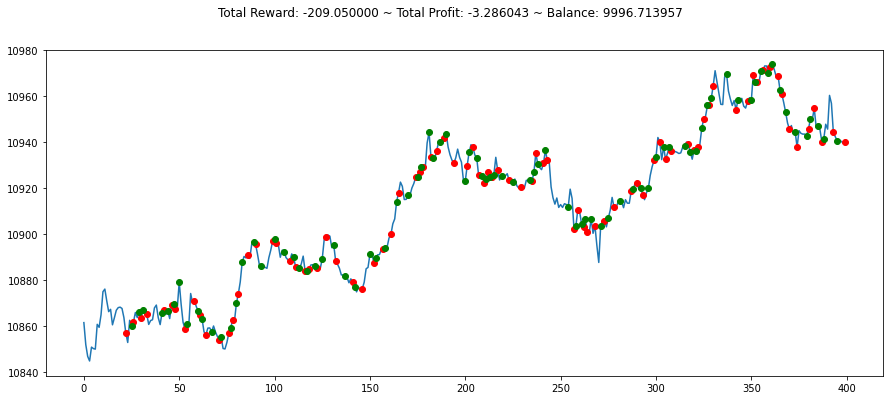

info {'total_reward': -198.2599999999984, 'total_profit': -31.05191125055171, 'balance': 9968.948088749448, 'position': 1}


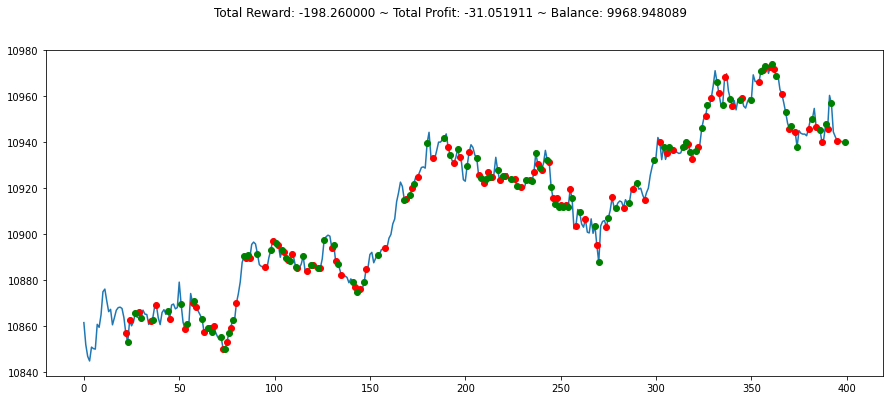

info {'total_reward': -75.56999999999971, 'total_profit': 82.45950622967939, 'balance': 10082.45950622968, 'position': 0}


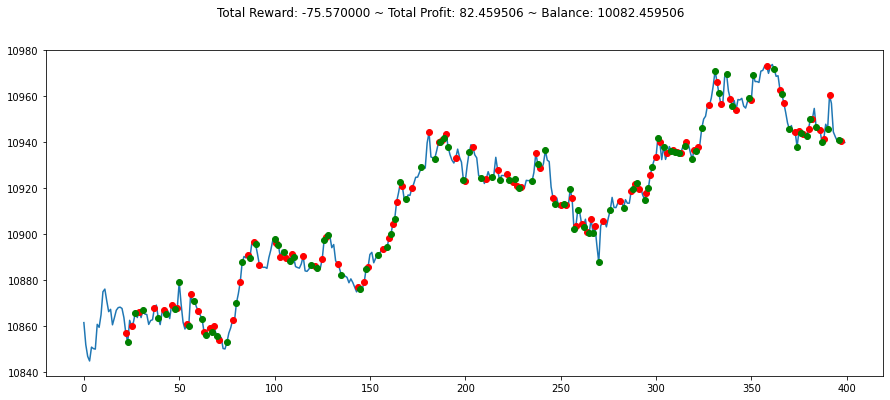

{'total_reward': -125.50000000000364, 'total_profit': 49.77584592848689, 'balance': 10049.775845928487, 'position': 1}
{'total_reward': -107.5899999999765, 'total_profit': 71.2294691071711, 'balance': 10071.229469107171, 'position': 1}
{'total_reward': -181.9599999999973, 'total_profit': 7.216750150251755, 'balance': 10007.216750150252, 'position': 1}
{'total_reward': -163.82000000000335, 'total_profit': 22.318140243627568, 'balance': 10022.318140243628, 'position': 1}
{'total_reward': -210.7500000000109, 'total_profit': -5.316883136794786, 'balance': 9994.683116863205, 'position': 0}
{'total_reward': -155.35000000001492, 'total_profit': 31.055952073096705, 'balance': 10031.055952073097, 'position': 0}
{'total_reward': -209.04999999999927, 'total_profit': -3.2860432087454683, 'balance': 9996.713956791255, 'position': 0}
{'total_reward': -198.2599999999984, 'total_profit': -31.05191125055171, 'balance': 9968.948088749448, 'position': 1}
{'total_reward': -75.56999999999971, 'total_profit

In [77]:
import random

#330483
# frame_bound=(22, 401)
infos = []
for j in range(1, 10):
  env = gym.make(id_str, df=df, frame_bound=(10001,10379), window_size=22)
  obs = env.reset()
  # done = False in due casi:
  #                     - quando viene fatta una azione invalida (ma a quanto pare ha imparato a non farne)
  #                     - quando finisce tutti i timesteps passati in frame bound. Siccome in step immediatamente viene fatto il +1 bisogna che impostare
  #                         range(frame_bound.min, frame_bound.max -1)
  for i in range(10001, 10378): 
      obs = obs[np.newaxis, ...]
      action, _states = model.predict(obs)
      obs, rewards, done, info = env.step(action)
      if done:
          print("info", info)
          infos.append(info)
          plt.figure(figsize=(15,6))
          plt.cla()
          env.render_all()
          plt.show()
          break
for i in infos:
  print(i)